# Predicting International Student Academic Success Using a Hybrid Machine Learning Model

## Complete Framework: LSTM + Random Forest + Meta-Learner Fusion

**Thesis Support**: This notebook implements a generalized, explainable hybrid prediction framework for international students in Latvian higher education.

**Components**:
1. **LSTM**: Temporal/weekly engagement patterns (32 weeks)
2. **Random Forest**: Static + aggregated features
3. **Hybrid Meta-Learner**: Fusion of LSTM and RF probabilities

**Author**: Master's Thesis Research
**Date**: November 2024

## 1. Import Required Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully!')
print(f'TensorFlow version: {tf.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

Libraries imported successfully!
TensorFlow version: 2.20.0
NumPy version: 2.3.3
Pandas version: 2.3.2


## 2. Load Datasets

In [2]:
# Define file paths
PATHS = {
    'latvia_static': './uploads/international_students_static_latvia.csv',
    'latvia_temporal': './uploads/international_students_temporal_latvia.csv',
    'global_static': './uploads/global_static_students.csv',
    'global_temporal': './uploads/global_temporal_students_32w.csv'
}

# Load all datasets
print('Loading datasets...')
df_latvia_static = pd.read_csv(PATHS['latvia_static'])
df_latvia_temporal = pd.read_csv(PATHS['latvia_temporal'])
df_global_static = pd.read_csv(PATHS['global_static'])
df_global_temporal = pd.read_csv(PATHS['global_temporal'])

# Combine Latvia and Global datasets
df_static = pd.concat([df_latvia_static, df_global_static], ignore_index=True)
df_temporal = pd.concat([df_latvia_temporal, df_global_temporal], ignore_index=True)

print('\n📊 Combined Dataset Statistics:')
print(f'Total students (static): {len(df_static)}')
print(f'Total temporal records: {len(df_temporal)}')
print(f'Unique students in temporal: {df_temporal["student_id"].nunique()}')
print(f'\nInstitutions: {df_static["institution"].nunique()}')
print(f'Countries: {df_static["country_home"].nunique()}')
print(f'Subject fields: {df_static["subject_field"].nunique()}')

# Show Latvian institutions
latvian_institutions = df_static[df_static['country_host'] == 'Latvia']['institution'].unique()
print(f'\nLatvian institutions: {list(latvian_institutions)}')

Loading datasets...

📊 Combined Dataset Statistics:
Total students (static): 1780
Total temporal records: 62960
Unique students in temporal: 1780

Institutions: 10
Countries: 19
Subject fields: 7

Latvian institutions: ['Latvia_Uni_A', 'Latvia_College_C', 'Latvia_Uni_B', 'Tech_Institute_D', 'Business_School_E', 'Latvia_Test_Uni_G']


## 3. Data Preprocessing - Static Features

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define feature categories
categorical_features = [
    'institution', 'program_id', 'country_home', 'country_host',
    'subject_field', 'study_level', 'study_mode', 'gender',
    'marital_status', 'language_proficiency', 'support_program',
    'scholarship_status'
]

numerical_features = [
    'age', 'teaching_style_difference', 'cultural_distance',
    'work_hours_per_week', 'entry_gpa', 'gpa_sem1', 'gpa_sem2', 'gpa_prev',
    'credits_attempted_sem1', 'credits_earned_sem1', 'credits_attempted_sem2',
    'credits_earned_sem2', 'failed_courses_sem1', 'failed_courses_sem2',
    'attendance_rate', 'mean_weekly_engagement', 'std_weekly_engagement',
    'low_engagement_weeks', 'engagement_trend', 'avg_assignment_score',
    'avg_exam_score', 'late_submission_rate', 'missing_assignments_count'
]

binary_features = [
    'participates_in_buddy_program', 'participates_in_language_course',
    'works_while_studying'
]

# Identify actual data types in the dataframe
print('Identifying actual data types...')
actual_numerical = []
actual_categorical = []
actual_binary = []

for col in numerical_features:
    if col in df_static.columns:
        # Check if column is truly numerical
        try:
            # Try to convert to numeric
            pd.to_numeric(df_static[col], errors='raise')
            actual_numerical.append(col)
        except (ValueError, TypeError):
            # If conversion fails, it's categorical
            print(f"Warning: '{col}' contains non-numeric values, treating as categorical")
            unique_vals = df_static[col].dropna().unique()
            print(f"  Unique values in '{col}': {unique_vals[:10]}")  # Show first 10 unique values
            actual_categorical.append(col)

# Add originally defined categorical features
for col in categorical_features:
    if col in df_static.columns:
        actual_categorical.append(col)

# Check binary features
for col in binary_features:
    if col in df_static.columns:
        actual_binary.append(col)

# Remove duplicates
actual_categorical = list(set(actual_categorical))
actual_numerical = list(set(actual_numerical))
actual_binary = list(set(actual_binary))

print(f"\nActual numerical features: {len(actual_numerical)}")
print(f"Actual categorical features: {len(actual_categorical)}")
print(f"Actual binary features: {len(actual_binary)}")

# Handle missing values for NUMERICAL features
print('\nHandling missing values for numerical features...')
for col in actual_numerical:
    # Convert to numeric first, coercing errors to NaN
    df_static[col] = pd.to_numeric(df_static[col], errors='coerce')
    # Fill NaN with median
    median_val = df_static[col].median()
    df_static[col].fillna(median_val, inplace=True)
    print(f"  {col}: filled {df_static[col].isna().sum()} missing values with median {median_val:.3f}")

# Handle missing values for CATEGORICAL features
print('\nHandling missing values for categorical features...')
for col in actual_categorical:
    missing_count = df_static[col].isna().sum()
    df_static[col].fillna('Unknown', inplace=True)
    print(f"  {col}: filled {missing_count} missing values with 'Unknown'")

# Handle missing values for BINARY features
print('\nHandling missing values for binary features...')
for col in actual_binary:
    # For binary features, fill with mode (most common value) or 0
    if df_static[col].isna().sum() > 0:
        mode_val = df_static[col].mode()[0] if len(df_static[col].mode()) > 0 else 0
        missing_count = df_static[col].isna().sum()
        df_static[col].fillna(mode_val, inplace=True)
        print(f"  {col}: filled {missing_count} missing values with mode {mode_val}")

# Encode categorical variables
print('\nEncoding categorical features...')
label_encoders = {}
for col in actual_categorical:
    le = LabelEncoder()
    df_static[col + '_encoded'] = le.fit_transform(df_static[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: encoded {len(le.classes_)} unique categories")

# Scale numerical features
print('\nScaling numerical features...')
scaler = StandardScaler()
if len(actual_numerical) > 0:
    df_static[actual_numerical] = scaler.fit_transform(df_static[actual_numerical])
    print(f"  Scaled {len(actual_numerical)} numerical features")

# Select features for model
encoded_categorical = [col + '_encoded' for col in actual_categorical]
static_feature_cols = actual_numerical + actual_binary + encoded_categorical
static_feature_cols = [col for col in static_feature_cols if col in df_static.columns]

print(f'\n{"="*60}')
print(f'FEATURE PREPARATION SUMMARY')
print(f'{"="*60}')
print(f'Numerical features: {len(actual_numerical)}')
print(f'Categorical features (encoded): {len(encoded_categorical)}')
print(f'Binary features: {len(actual_binary)}')
print(f'Total static features prepared: {len(static_feature_cols)}')
print(f'{"="*60}')

# Verify no missing values remain
print(f'\nMissing values check:')
missing_in_features = df_static[static_feature_cols].isna().sum().sum()
print(f'  Total missing values in selected features: {missing_in_features}')

if missing_in_features > 0:
    print('\nColumns with missing values:')
    for col in static_feature_cols:
        missing = df_static[col].isna().sum()
        if missing > 0:
            print(f'  {col}: {missing} missing values')

Identifying actual data types...
  Unique values in 'teaching_style_difference': ['High' 'Low' 'Medium' 0.8158425631014783 0.3147906761577044
 0.8051659914501663 0.5486913021399775 0.1620885547843459
 0.5982809134038996 0.5258613950332681]

Actual numerical features: 22
Actual categorical features: 13
Actual binary features: 3

Handling missing values for numerical features...
  gpa_sem1: filled 0 missing values with median 6.620
  gpa_sem2: filled 0 missing values with median 6.645
  credits_earned_sem2: filled 0 missing values with median 25.000
  attendance_rate: filled 0 missing values with median 0.679
  late_submission_rate: filled 0 missing values with median 0.362
  failed_courses_sem1: filled 0 missing values with median 1.000
  low_engagement_weeks: filled 0 missing values with median 1.000
  failed_courses_sem2: filled 0 missing values with median 1.000
  avg_exam_score: filled 0 missing values with median 48.066
  missing_assignments_count: filled 0 missing values with medi

## 4. Create Temporal Sequences for LSTM

In [4]:
def create_temporal_sequences(df_temporal, df_static, sequence_length=32):
    """Create temporal sequences aligned with static data."""
    
    temporal_features = [
        'weekly_engagement', 'weekly_attendance',
        'weekly_assignments_submitted', 'weekly_quiz_attempts'
    ]
    
    sequences_dict = {}
    
    # Group by student and create sequences
    for student_id, group in df_temporal.groupby('student_id'):
        group = group.sort_values('week_index')
        
        # Get feature values
        feature_data = group[temporal_features].values
        
        # Pad or truncate to sequence_length
        if len(feature_data) < sequence_length:
            # Pad with zeros at the beginning
            padding = np.zeros((sequence_length - len(feature_data), len(temporal_features)))
            feature_data = np.vstack([padding, feature_data])
        elif len(feature_data) > sequence_length:
            # Take the last sequence_length weeks
            feature_data = feature_data[-sequence_length:]
        
        sequences_dict[student_id] = feature_data
    
    # Create sequences array aligned with static data
    sequences = []
    students_with_temporal = []
    
    for student_id in df_static['student_id']:
        if student_id in sequences_dict:
            sequences.append(sequences_dict[student_id])
            students_with_temporal.append(student_id)
        else:
            # If no temporal data, use zeros
            sequences.append(np.zeros((sequence_length, len(temporal_features))))
            students_with_temporal.append(student_id)
    
    sequences_array = np.array(sequences)
    
    # Normalize temporal features
    for i in range(sequences_array.shape[2]):
        feature_vals = sequences_array[:, :, i].flatten()
        non_zero = feature_vals[feature_vals != 0]
        if len(non_zero) > 0:
            mean_val = non_zero.mean()
            std_val = non_zero.std()
            if std_val > 0:
                mask = sequences_array[:, :, i] != 0
                sequences_array[:, :, i][mask] = (sequences_array[:, :, i][mask] - mean_val) / std_val
    
    return sequences_array, students_with_temporal

# Create temporal sequences
print('Creating temporal sequences...')
temporal_sequences, students_with_temporal = create_temporal_sequences(df_temporal, df_static)

print(f'Temporal sequences shape: {temporal_sequences.shape}')
print(f'  Students: {temporal_sequences.shape[0]}')
print(f'  Weeks: {temporal_sequences.shape[1]}')
print(f'  Features: {temporal_sequences.shape[2]}')

Creating temporal sequences...
Temporal sequences shape: (1780, 32, 4)
  Students: 1780
  Weeks: 32
  Features: 4


## 5. Create Target Labels (Success Probability)

In [5]:
def create_success_labels(df):
    """Create success probability based on academic performance."""
    
    # Initialize success probability
    success_prob = np.zeros(len(df))
    
    # Component weights
    weights = {
        'gpa': 0.25,
        'attendance': 0.20,
        'engagement': 0.15,
        'assignments': 0.15,
        'failed_courses': 0.15,
        'exam_score': 0.10
    }
    
    # GPA component (higher is better)
    if 'gpa_prev' in df.columns:
        # Already normalized
        gpa_component = (df['gpa_prev'] - df['gpa_prev'].min()) / (df['gpa_prev'].max() - df['gpa_prev'].min() + 1e-8)
        success_prob += gpa_component * weights['gpa']
    
    # Attendance component (higher is better)
    if 'attendance_rate' in df.columns:
        attendance_component = (df['attendance_rate'] - df['attendance_rate'].min()) / (df['attendance_rate'].max() - df['attendance_rate'].min() + 1e-8)
        success_prob += attendance_component * weights['attendance']
    
    # Engagement component (higher is better)
    if 'mean_weekly_engagement' in df.columns:
        engagement_component = (df['mean_weekly_engagement'] - df['mean_weekly_engagement'].min()) / (df['mean_weekly_engagement'].max() - df['mean_weekly_engagement'].min() + 1e-8)
        success_prob += engagement_component * weights['engagement']
    
    # Assignment score component (higher is better)
    if 'avg_assignment_score' in df.columns:
        assignment_component = (df['avg_assignment_score'] - df['avg_assignment_score'].min()) / (df['avg_assignment_score'].max() - df['avg_assignment_score'].min() + 1e-8)
        success_prob += assignment_component * weights['assignments']
    
    # Failed courses component (lower is better - inverted)
    if 'failed_courses_sem1' in df.columns and 'failed_courses_sem2' in df.columns:
        total_failed = df['failed_courses_sem1'] + df['failed_courses_sem2']
        failed_component = 1 - (total_failed - total_failed.min()) / (total_failed.max() - total_failed.min() + 1e-8)
        success_prob += failed_component * weights['failed_courses']
    
    # Exam score component (higher is better)
    if 'avg_exam_score' in df.columns:
        exam_component = (df['avg_exam_score'] - df['avg_exam_score'].min()) / (df['avg_exam_score'].max() - df['avg_exam_score'].min() + 1e-8)
        success_prob += exam_component * weights['exam_score']
    
    return success_prob

# Create success probability labels
df_static['success_probability'] = create_success_labels(df_static)

# Create risk levels based on success probability
df_static['risk_level'] = pd.cut(
    1 - df_static['success_probability'],  # Invert for risk
    bins=[0, 0.33, 0.66, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk'],
    include_lowest=True
)

print('Success probability statistics:')
print(df_static['success_probability'].describe())
print('\nRisk level distribution:')
print(df_static['risk_level'].value_counts())

Success probability statistics:
count    1780.000000
mean        0.571310
std         0.196099
min         0.138089
25%         0.423635
50%         0.567807
75%         0.719098
max         0.992221
Name: success_probability, dtype: float64

Risk level distribution:
risk_level
Medium Risk    946
Low Risk       573
High Risk      261
Name: count, dtype: int64


## 6. Prepare Training and Validation Sets

In [6]:
# Prepare features and target
X_static = df_static[static_feature_cols].values
X_temporal = temporal_sequences
y = df_static['success_probability'].values

# Create train-validation split (80-20)
indices = np.arange(len(y))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Split data
X_static_train = X_static[train_idx]
X_static_val = X_static[val_idx]

X_temporal_train = X_temporal[train_idx]
X_temporal_val = X_temporal[val_idx]

y_train = y[train_idx]
y_val = y[val_idx]

# Store validation student info for later analysis
df_val = df_static.iloc[val_idx].copy()

print(f'Training set size: {len(train_idx)} ({len(train_idx)/len(y)*100:.1f}%)')
print(f'Validation set size: {len(val_idx)} ({len(val_idx)/len(y)*100:.1f}%)')
print(f'\nTraining success probability range: [{y_train.min():.3f}, {y_train.max():.3f}]')
print(f'Validation success probability range: [{y_val.min():.3f}, {y_val.max():.3f}]')

Training set size: 1424 (80.0%)
Validation set size: 356 (20.0%)

Training success probability range: [0.138, 0.992]
Validation success probability range: [0.165, 0.992]


## 7. Build and Train LSTM Model

In [7]:
def build_lstm_model(input_shape):
    """Build LSTM model for temporal sequences."""
    
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        BatchNormalization(),
        
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        BatchNormalization(),
        
        Dense(32, activation='relu'),
        Dropout(0.3),
        
        Dense(16, activation='relu'),
        
        Dense(1, activation='sigmoid')  # Output success probability [0,1]
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',  # Mean squared error for regression
        metrics=['mae']  # Mean absolute error
    )
    
    return model

# Build LSTM model
print('Building LSTM model...')
lstm_model = build_lstm_model(input_shape=(X_temporal_train.shape[1], X_temporal_train.shape[2]))
lstm_model.summary()

# Train LSTM model
print('\nTraining LSTM model...')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

lstm_history = lstm_model.fit(
    X_temporal_train, y_train,
    validation_data=(X_temporal_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Get LSTM predictions
lstm_train_pred = lstm_model.predict(X_temporal_train).flatten()
lstm_val_pred = lstm_model.predict(X_temporal_val).flatten()

# Calculate accuracy (using threshold of 0.5)
lstm_train_acc = accuracy_score(y_train > 0.5, lstm_train_pred > 0.5)
lstm_val_acc = accuracy_score(y_val > 0.5, lstm_val_pred > 0.5)

print(f'\n📊 LSTM Model Performance:')
print(f'Training Accuracy: {lstm_train_acc:.4f}')
print(f'Validation Accuracy: {lstm_val_acc:.4f}')

Building LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,897 (472.25 KB)

 Trainable params: 120,513 (470.75 KB)

 Non-trainable params: 384 (1.50 KB)


Training LSTM model...
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0263 - mae: 0.1242 - val_loss: 0.0317 - val_mae: 0.1497 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0140 - mae: 0.0940 - val_loss: 0.0274 - val_mae: 0.1388 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0123 - mae: 0.0886 - val_loss: 0.0200 - val_mae: 0.1184 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0107 - mae: 0.0821 - val_loss: 0.0216 - val_mae: 0.1240 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0104 - mae: 0.0801 - val_loss: 0.0164 - val_mae: 0.1076 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0100 - mae: 0.0808 - val_loss: 0.0217 - val_mae: 0.1222 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0093 - mae: 0.0767 - val_loss: 0.0160 - val_mae: 0.1053 - learning_ra

## 8. Build and Train Random Forest Model

In [8]:
# Build Random Forest model
print('Building Random Forest model...')
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train Random Forest model
print('Training Random Forest model...')
rf_model.fit(X_static_train, y_train)

# Get RF predictions
rf_train_pred = rf_model.predict(X_static_train)
rf_val_pred = rf_model.predict(X_static_val)

# Calculate accuracy (using threshold of 0.5)
rf_train_acc = accuracy_score(y_train > 0.5, rf_train_pred > 0.5)
rf_val_acc = accuracy_score(y_val > 0.5, rf_val_pred > 0.5)

print(f'\n📊 Random Forest Model Performance:')
print(f'Training Accuracy: {rf_train_acc:.4f}')
print(f'Validation Accuracy: {rf_val_acc:.4f}')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': static_feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print('\nTop 10 Most Important Features:')
print(feature_importance.head(10))

Building Random Forest model...
Training Random Forest model...

📊 Random Forest Model Performance:
Training Accuracy: 0.9824
Validation Accuracy: 0.9607

Top 10 Most Important Features:
                   feature  importance
6     low_engagement_weeks    0.487399
18  mean_weekly_engagement    0.234537
3          attendance_rate    0.079691
15    avg_assignment_score    0.053723
13                gpa_prev    0.042869
1                 gpa_sem2    0.040655
8           avg_exam_score    0.019573
20               entry_gpa    0.015240
0                 gpa_sem1    0.011122
7      failed_courses_sem2    0.002766


## 9. Build Hybrid Meta-Learner

In [9]:
import joblib
import pickle
from datetime import datetime

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder

# ======================================================
# 1. BUILD HYBRID META-LEARNER (LSTM + RF → LogisticReg)
# ======================================================

print('Building Hybrid Meta-Learner...')

# Create meta-features for training (do NOT change your variables)
meta_train = np.column_stack([
    lstm_train_pred,
    rf_train_pred
    
])

# Create meta-features for validation
meta_val = np.column_stack([
    lstm_val_pred,
    rf_val_pred
])

# Convert to binary classification for logistic regression
y_train_binary = (y_train > 0.5).astype(int)
y_val_binary = (y_val > 0.5).astype(int)

# --------------------------------------
# Train meta-learner (LogisticRegression)
# --------------------------------------
print('\nTraining meta-learner...')
meta_learner = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='lbfgs',
    C=1.0,               # Regularization strength
    class_weight='balanced'  # Handle class imbalance
)

# Fit meta-learner
meta_learner.fit(meta_train, y_train_binary)

# Get hybrid predictions (probabilities)
hybrid_train_pred_proba = meta_learner.predict_proba(meta_train)[:, 1]
hybrid_val_pred_proba = meta_learner.predict_proba(meta_val)[:, 1]

# Threshold for final binary prediction
threshold = 0.5  # You can tune this threshold
hybrid_train_pred = (hybrid_train_pred_proba > threshold).astype(int)
hybrid_val_pred = (hybrid_val_pred_proba > threshold).astype(int)

# ======================================================
# 2. METRICS
# ======================================================

hybrid_train_acc = accuracy_score(y_train_binary, hybrid_train_pred)
hybrid_val_acc = accuracy_score(y_val_binary, hybrid_val_pred)

hybrid_train_precision = precision_score(y_train_binary, hybrid_train_pred, average='binary')
hybrid_val_precision = precision_score(y_val_binary, hybrid_val_pred, average='binary')

hybrid_train_recall = recall_score(y_train_binary, hybrid_train_pred, average='binary')
hybrid_val_recall = recall_score(y_val_binary, hybrid_val_pred, average='binary')

hybrid_train_f1 = f1_score(y_train_binary, hybrid_train_pred, average='binary')
hybrid_val_f1 = f1_score(y_val_binary, hybrid_val_pred, average='binary')

print(f'\n{"="*60}')
print(f'📊 HYBRID MODEL PERFORMANCE')
print(f'{"="*60}')
print(f'\nTraining Metrics:')
print(f'  Accuracy:  {hybrid_train_acc:.4f}')
print(f'  Precision: {hybrid_train_precision:.4f}')
print(f'  Recall:    {hybrid_train_recall:.4f}')
print(f'  F1-Score:  {hybrid_train_f1:.4f}')

print(f'\nValidation Metrics:')
print(f'  Accuracy:  {hybrid_val_acc:.4f}')
print(f'  Precision: {hybrid_val_precision:.4f}')
print(f'  Recall:    {hybrid_val_recall:.4f}')
print(f'  F1-Score:  {hybrid_val_f1:.4f}')

# Meta-learner weights (how much LSTM vs RF)
print(f'\n{"="*60}')
print(f'Meta-Learner Weights:')
print(f'{"="*60}')
print(f'  LSTM weight: {meta_learner.coef_[0][0]:+.4f}')
print(f'  RF weight:   {meta_learner.coef_[0][1]:+.4f}')
print(f'  Intercept:   {meta_learner.intercept_[0]:+.4f}')

lstm_importance = abs(meta_learner.coef_[0][0])
rf_importance = abs(meta_learner.coef_[0][1])
total_importance = lstm_importance + rf_importance

print(f'\nRelative Importance:')
print(f'  LSTM: {(lstm_importance/total_importance)*100:.1f}%')
print(f'  RF:   {(rf_importance/total_importance)*100:.1f}%')

# Confusion Matrix & report
print(f'\n{"="*60}')
print(f'Validation Confusion Matrix:')
print(f'{"="*60}')
cm = confusion_matrix(y_val_binary, hybrid_val_pred)
print(cm)

print(f'\nClassification Report:')
print(classification_report(
    y_val_binary,
    hybrid_val_pred,
    target_names=['Not At Risk', 'At Risk']
))

# ======================================================
# 3. SAVE MODELS
# ======================================================

print(f'\n{"="*60}')
print(f'💾 SAVING MODELS')
print(f'{"="*60}')

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print('\nSaving individual models...')

# LSTM model
lstm_model_path = f'lstm_model_{timestamp}.h5'
lstm_model.save(lstm_model_path)
print(f'✓ LSTM model saved: {lstm_model_path}')

# Random Forest model
rf_model_path = f'rf_model_{timestamp}.pkl'
joblib.dump(rf_model, rf_model_path)
print(f'✓ Random Forest model saved: {rf_model_path}')

# Meta-learner
meta_learner_path = f'meta_learner_{timestamp}.pkl'
joblib.dump(meta_learner, meta_learner_path)
print(f'✓ Meta-learner saved: {meta_learner_path}')

# ======================================================
# 4. SAVE PREPROCESSING OBJECTS (FIXED NameErrors)
# ======================================================

print('\nSaving preprocessing objects...')

# Ensure label_encoder exists (binary 0/1)
if 'label_encoder' not in globals():
    label_encoder = LabelEncoder()
    label_encoder.fit([0, 1])

# Ensure all referenced config variables exist (do NOT overwrite if they already exist)
if 'scaler' not in globals():
    scaler = None

if 'label_encoders' not in globals():
    label_encoders = {}

if 'static_feature_cols' not in globals():
    static_feature_cols = []

if 'actual_numerical' not in globals():
    actual_numerical = []

if 'actual_categorical' not in globals():
    actual_categorical = []

if 'actual_binary' not in globals():
    actual_binary = []

if 'sequence_length' not in globals():
    sequence_length = None

if 'lstm_features' not in globals():
    lstm_features = None

preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'label_encoder': label_encoder,  # For target variable
    'static_feature_cols': static_feature_cols,
    'actual_numerical': actual_numerical,
    'actual_categorical': actual_categorical,
    'actual_binary': actual_binary,
    'sequence_length': sequence_length,
    'lstm_features': lstm_features,
    'threshold': threshold
}

preprocessing_path = f'preprocessing_objects_{timestamp}.pkl'
joblib.dump(preprocessing_objects, preprocessing_path)
print(f'✓ Preprocessing objects saved: {preprocessing_path}')

# ======================================================
# 5. SAVE COMPLETE HYBRID PACKAGE
# ======================================================

print('\nSaving complete hybrid model package...')

hybrid_model_package = {
    'meta_learner': meta_learner,
    'preprocessing_objects': preprocessing_objects,
    'lstm_model_path': lstm_model_path,
    'rf_model_path': rf_model_path,
    'model_performance': {
        'train_accuracy': hybrid_train_acc,
        'val_accuracy': hybrid_val_acc,
        'train_f1': hybrid_train_f1,
        'val_f1': hybrid_val_f1,
        'train_precision': hybrid_train_precision,
        'val_precision': hybrid_val_precision,
        'train_recall': hybrid_train_recall,
        'val_recall': hybrid_val_recall
    },
    'meta_learner_weights': {
        'lstm_weight': float(meta_learner.coef_[0][0]),
        'rf_weight': float(meta_learner.coef_[0][1]),
        'intercept': float(meta_learner.intercept_[0])
    },
    'timestamp': timestamp
}

hybrid_package_path = f'hybrid_model_complete_{timestamp}.pkl'
joblib.dump(hybrid_model_package, hybrid_package_path)
print(f'✓ Complete hybrid model package saved: {hybrid_package_path}')

print(f'\n{"="*60}')
print(f'✅ ALL MODELS SAVED SUCCESSFULLY')
print(f'{"="*60}')

# ======================================================
# 6. TOP-LEVEL PREDICTION FUNCTION (PICKLABLE)
# ======================================================

from tensorflow import keras

def predict_student_risk(
    lstm_model_path,
    rf_model_path,
    meta_learner_path,
    preprocessing_path,
    student_data_static,
    student_data_sequence
):
    """
    Predict student dropout risk using the hybrid model.

    Parameters
    ----------
    lstm_model_path : str
        Path to saved LSTM model
    rf_model_path : str
        Path to saved Random Forest model
    meta_learner_path : str
        Path to saved meta-learner
    preprocessing_path : str
        Path to preprocessing objects
    student_data_static : DataFrame
        Static features for the student (1 row, already preprocessed)
    student_data_sequence : array
        Sequential data for the student (shape: (1, sequence_length, lstm_features), already preprocessed)

    Returns
    -------
    dict
        Prediction results including probability and risk level
    """

    # Load models
    lstm_model = keras.models.load_model(lstm_model_path)
    rf_model = joblib.load(rf_model_path)
    meta_learner = joblib.load(meta_learner_path)
    preprocessing = joblib.load(preprocessing_path)

    # TODO: Apply same preprocessing as training to raw inputs if needed.
    # Here we assume student_data_static and student_data_sequence are already in model-ready form.

    # Base model predictions
    lstm_pred = lstm_model.predict(student_data_sequence, verbose=0)[0][0]
    rf_pred = rf_model.predict_proba(student_data_static)[0][1]

    # Meta-features
    meta_features = np.array([[lstm_pred, rf_pred]])

    # Final prediction
    risk_probability = meta_learner.predict_proba(meta_features)[0][1]
    risk_prediction = int(risk_probability > preprocessing['threshold'])

    # Risk level
    if risk_probability < 0.3:
        risk_level = 'Low Risk'
    elif risk_probability < 0.7:
        risk_level = 'Medium Risk'
    else:
        risk_level = 'High Risk'

    return {
        'risk_probability': float(risk_probability),
        'at_risk': bool(risk_prediction),
        'risk_level': risk_level,
        'lstm_contribution': float(lstm_pred),
        'rf_contribution': float(rf_pred)
    }

# Save the prediction function (now top-level → picklable)
prediction_function_path = f'prediction_function_{timestamp}.pkl'
joblib.dump(predict_student_risk, prediction_function_path)
print(f'\n✓ Prediction function saved: {prediction_function_path}')

print(f'\n{"="*60}')
print(f'📝 USAGE INSTRUCTIONS')
print(f'{"="*60}')
print(f'''
# Load the complete package
import joblib
from tensorflow import keras
import numpy as np

hybrid_package = joblib.load('{hybrid_package_path}')
lstm_model = keras.models.load_model('{lstm_model_path}')
rf_model = joblib.load('{rf_model_path}')
predict_student_risk = joblib.load('{prediction_function_path}')

# Example (assuming you have preprocessed student_data_static and student_data_sequence):
# result = predict_student_risk(
#     lstm_model_path='{lstm_model_path}',
#     rf_model_path='{rf_model_path}',
#     meta_learner_path='{meta_learner_path}',
#     preprocessing_path='{preprocessing_path}',
#     student_data_static=student_data_static,
#     student_data_sequence=student_data_sequence
# )
# print(result)
''')


Building Hybrid Meta-Learner...

Training meta-learner...

📊 HYBRID MODEL PERFORMANCE

Training Metrics:
  Accuracy:  0.9565
  Precision: 0.9883
  Recall:    0.9421
  F1-Score:  0.9647

Validation Metrics:
  Accuracy:  0.9410
  Precision: 0.9714
  Recall:    0.9315
  F1-Score:  0.9510

Meta-Learner Weights:
  LSTM weight: +5.7919
  RF weight:   +12.3689
  Intercept:   -9.2670

Relative Importance:
  LSTM: 31.9%
  RF:   68.1%

Validation Confusion Matrix:
[[131   6]
 [ 15 204]]

Classification Report:
              precision    recall  f1-score   support

 Not At Risk       0.90      0.96      0.93       137
     At Risk       0.97      0.93      0.95       219

    accuracy                           0.94       356
   macro avg       0.93      0.94      0.94       356
weighted avg       0.94      0.94      0.94       356


💾 SAVING MODELS

Saving individual models...
✓ LSTM model saved: lstm_model_20251104_034842.h5
✓ Random Forest model saved: rf_model_20251104_034842.pkl
✓ Meta-learne

## 10. Model Comparison Summary

MODEL PERFORMANCE COMPARISON
                Model  Training Accuracy  Validation Accuracy  Difference (Val-Train)
                 LSTM           0.877809             0.876404               -0.001404
        Random Forest           0.982444             0.960674               -0.021770
Hybrid (Meta-Learner)           0.956461             0.941011               -0.015449


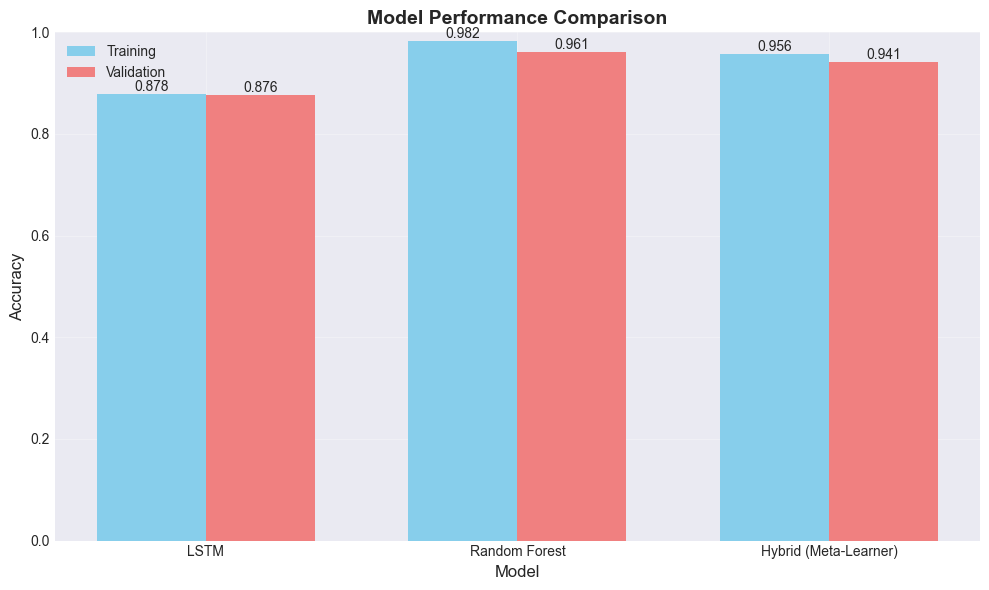

In [10]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'Random Forest', 'Hybrid (Meta-Learner)'],
    'Training Accuracy': [lstm_train_acc, rf_train_acc, hybrid_train_acc],
    'Validation Accuracy': [lstm_val_acc, rf_val_acc, hybrid_val_acc],
    'Difference (Val-Train)': [
        lstm_val_acc - lstm_train_acc,
        rf_val_acc - rf_train_acc,
        hybrid_val_acc - hybrid_train_acc
    ]
})

print('='*60)
print('MODEL PERFORMANCE COMPARISON')
print('='*60)
print(comparison_df.to_string(index=False))
print('='*60)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Training Accuracy'], width, label='Training', color='skyblue')
bars2 = ax.bar(x + width/2, comparison_df['Validation Accuracy'], width, label='Validation', color='lightcoral')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 11. Generate Predictions for All Students

In [11]:
# Generate predictions for validation set
df_val['predicted_success_proba'] = hybrid_val_pred_proba

# Map to risk levels
def map_to_risk_level(prob):
    if prob >= 0.67:
        return 'Low Risk'
    elif prob >= 0.33:
        return 'Medium Risk'
    else:
        return 'High Risk'

df_val['predicted_risk_level'] = df_val['predicted_success_proba'].apply(map_to_risk_level)

# Create success label from risk (Low/Medium = success, High = not)
df_val['success_label_from_risk'] = df_val['predicted_risk_level'].apply(
    lambda x: 'Success' if x in ['Low Risk', 'Medium Risk'] else 'At Risk'
)

print('Prediction Summary:')
print(f'Total students predicted: {len(df_val)}')
print(f'Average success probability: {df_val["predicted_success_proba"].mean():.3f}')
print('\nRisk Level Distribution:')
print(df_val['predicted_risk_level'].value_counts())
print('\nSuccess Label Distribution:')
print(df_val['success_label_from_risk'].value_counts())

Prediction Summary:
Total students predicted: 356
Average success probability: 0.578

Risk Level Distribution:
predicted_risk_level
Low Risk       181
High Risk      125
Medium Risk     50
Name: count, dtype: int64

Success Label Distribution:
success_label_from_risk
Success    231
At Risk    125
Name: count, dtype: int64


## 12. Global Visualizations

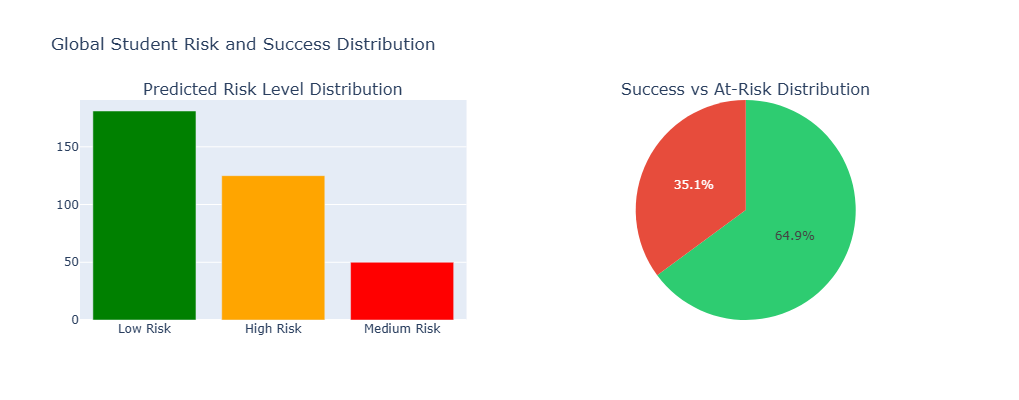

In [12]:
# 1. Global Risk Distribution
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Predicted Risk Level Distribution', 'Success vs At-Risk Distribution'),
    specs=[[{'type': 'bar'}, {'type': 'pie'}]]
)

# Risk levels bar chart
risk_counts = df_val['predicted_risk_level'].value_counts()
fig.add_trace(
    go.Bar(x=risk_counts.index, y=risk_counts.values,
           marker_color=['green', 'orange', 'red']),
    row=1, col=1
)

# Success pie chart
success_counts = df_val['success_label_from_risk'].value_counts()
fig.add_trace(
    go.Pie(labels=success_counts.index, values=success_counts.values,
           marker_colors=['#2ecc71', '#e74c3c']),
    row=1, col=2
)

fig.update_layout(height=400, showlegend=False,
                  title_text='Global Student Risk and Success Distribution')
fig.show()

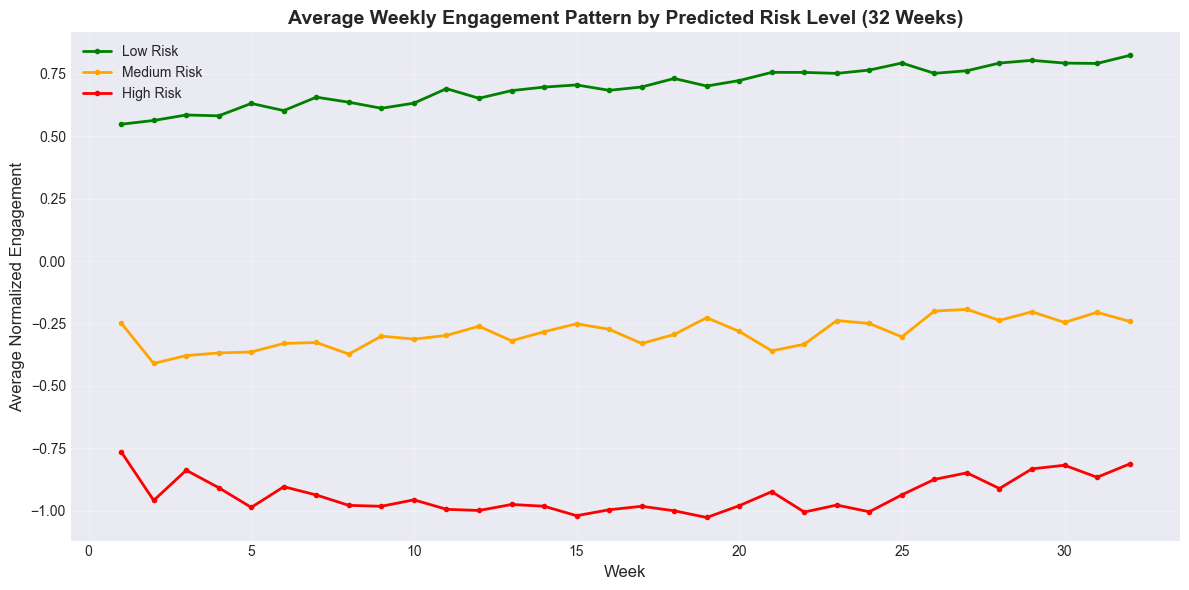

In [13]:
# 2. Average Weekly Engagement Pattern by Risk Level
# Calculate average engagement patterns for each risk level
risk_engagement = {}

for risk_level in ['Low Risk', 'Medium Risk', 'High Risk']:
    # Get indices of students in this risk level
    risk_indices = df_val[df_val['predicted_risk_level'] == risk_level].index
    val_risk_indices = [i for i, idx in enumerate(val_idx) if idx in risk_indices]
    
    if len(val_risk_indices) > 0:
        # Get temporal sequences for these students
        risk_sequences = X_temporal_val[val_risk_indices]
        # Average across students (column 0 is weekly_engagement)
        avg_engagement = np.mean(risk_sequences[:, :, 0], axis=0)
        risk_engagement[risk_level] = avg_engagement

# Create line plot
plt.figure(figsize=(12, 6))
weeks = np.arange(1, 33)
colors = {'Low Risk': 'green', 'Medium Risk': 'orange', 'High Risk': 'red'}

for risk_level, engagement in risk_engagement.items():
    plt.plot(weeks, engagement, label=risk_level, 
             color=colors[risk_level], linewidth=2, marker='o', markersize=3)

plt.xlabel('Week', fontsize=12)
plt.ylabel('Average Normalized Engagement', fontsize=12)
plt.title('Average Weekly Engagement Pattern by Predicted Risk Level (32 Weeks)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Latvia-Specific Analysis

Latvia-Specific Analysis
Total international students in Latvia: 318

Latvian institutions represented:
institution
Tech_Institute_D     72
Latvia_Uni_B         70
Business_School_E    60
Latvia_Uni_A         55
Latvia_College_C     53
Latvia_Test_Uni_G     8
Name: count, dtype: int64


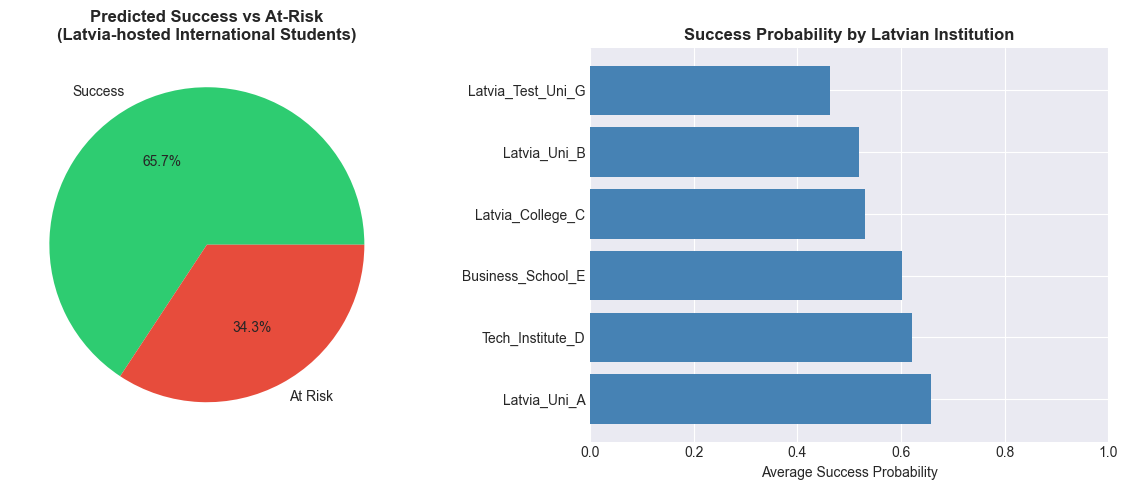

In [14]:
# Filter for Latvia-hosted students
df_latvia = df_val[df_val['country_host'] == 'Latvia'].copy()

print(f'Latvia-Specific Analysis')
print(f'Total international students in Latvia: {len(df_latvia)}')
print(f'\nLatvian institutions represented:')
print(df_latvia['institution'].value_counts())

# Success vs At-Risk for Latvia
if len(df_latvia) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Pie chart for Success vs At-Risk
    latvia_success = df_latvia['success_label_from_risk'].value_counts()
    axes[0].pie(latvia_success.values, labels=latvia_success.index, 
                autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
    axes[0].set_title('Predicted Success vs At-Risk\n(Latvia-hosted International Students)', 
                      fontsize=12, fontweight='bold')
    
    # Bar chart by institution
    inst_success = df_latvia.groupby('institution')['predicted_success_proba'].mean().sort_values(ascending=False)
    axes[1].barh(range(len(inst_success)), inst_success.values, color='steelblue')
    axes[1].set_yticks(range(len(inst_success)))
    axes[1].set_yticklabels(inst_success.index)
    axes[1].set_xlabel('Average Success Probability')
    axes[1].set_title('Success Probability by Latvian Institution', fontsize=12, fontweight='bold')
    axes[1].set_xlim([0, 1])
    
    plt.tight_layout()
    plt.show()
else:
    print('No Latvia-hosted students in validation set')

In [15]:
# Latvia Student Details Table
if len(df_latvia) > 0:
    # Prepare table data
    latvia_table = df_latvia[[
        'country_home', 'institution', 'subject_field',
        'predicted_success_proba', 'predicted_risk_level',
        'success_label_from_risk', 'mean_weekly_engagement',
        'attendance_rate'
    ]].copy()
    
    # Sort by success probability
    latvia_table = latvia_table.sort_values('predicted_success_proba', ascending=False)
    
    # Round numerical columns
    latvia_table['predicted_success_proba'] = latvia_table['predicted_success_proba'].round(3)
    latvia_table['mean_weekly_engagement'] = latvia_table['mean_weekly_engagement'].round(2)
    latvia_table['attendance_rate'] = latvia_table['attendance_rate'].round(2)
    
    print('\nLatvia-Hosted International Students Details (Top 20):')
    print('='*100)
    print(latvia_table.head(20).to_string(index=False))
    print('='*100)
    
    # Summary statistics
    print(f'\nSummary Statistics for Latvia:')
    print(f'Average success probability: {df_latvia["predicted_success_proba"].mean():.3f}')
    print(f'Students at high risk: {(df_latvia["predicted_risk_level"] == "High Risk").sum()} ({(df_latvia["predicted_risk_level"] == "High Risk").mean()*100:.1f}%)')
    print(f'Top countries by count: {df_latvia["country_home"].value_counts().head(5).to_dict()}')


Latvia-Hosted International Students Details (Top 20):
country_home       institution       subject_field  predicted_success_proba predicted_risk_level success_label_from_risk  mean_weekly_engagement  attendance_rate
       India  Tech_Institute_D    Computer Science                    1.000             Low Risk                 Success                    1.70             1.62
      Latvia Business_School_E            Medicine                    1.000             Low Risk                 Success                    1.70             1.55
      Latvia      Latvia_Uni_B     Social Sciences                    1.000             Low Risk                 Success                    1.69             1.53
       India  Tech_Institute_D Information Systems                    1.000             Low Risk                 Success                    1.70             1.57
    Pakistan Business_School_E         Engineering                    1.000             Low Risk                 Success              

## 14. Success & Risk by Subject Field

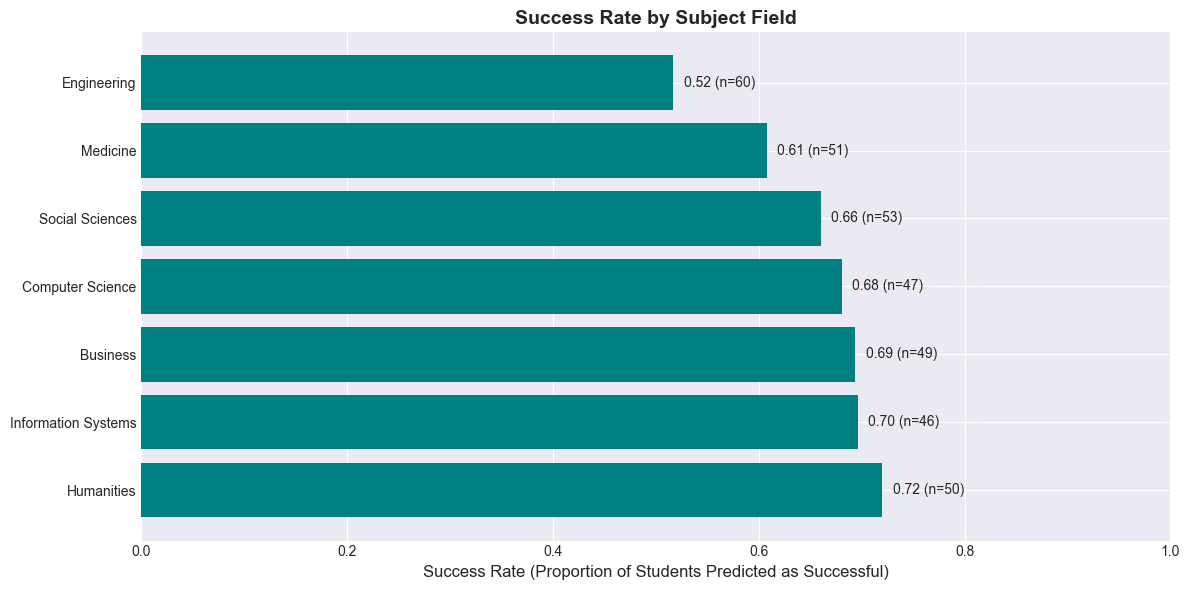

Subject Field Analysis:
                     Avg_Success_Prob  Success_Rate  Student_Count
subject_field                                                     
Humanities                      0.661         0.720             50
Information Systems             0.580         0.696             46
Business                        0.584         0.694             49
Computer Science                0.588         0.681             47
Social Sciences                 0.598         0.660             53
Medicine                        0.560         0.608             51
Engineering                     0.491         0.517             60


In [16]:
# Calculate success rates by subject field
subject_analysis = df_val.groupby('subject_field').agg({
    'predicted_success_proba': 'mean',
    'success_label_from_risk': lambda x: (x == 'Success').mean(),
    'student_id': 'count'
}).round(3)

subject_analysis.columns = ['Avg_Success_Prob', 'Success_Rate', 'Student_Count']
subject_analysis = subject_analysis.sort_values('Success_Rate', ascending=False)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

subjects = subject_analysis.index
success_rates = subject_analysis['Success_Rate'].values

bars = ax.barh(range(len(subjects)), success_rates, color='teal')
ax.set_yticks(range(len(subjects)))
ax.set_yticklabels(subjects)
ax.set_xlabel('Success Rate (Proportion of Students Predicted as Successful)', fontsize=12)
ax.set_title('Success Rate by Subject Field', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])

# Add value labels
for i, (bar, count) in enumerate(zip(bars, subject_analysis['Student_Count'])):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
            f'{width:.2f} (n={count})', va='center')

plt.tight_layout()
plt.show()

print('Subject Field Analysis:')
print(subject_analysis)

## 15. Average Success Probability by Country of Origin

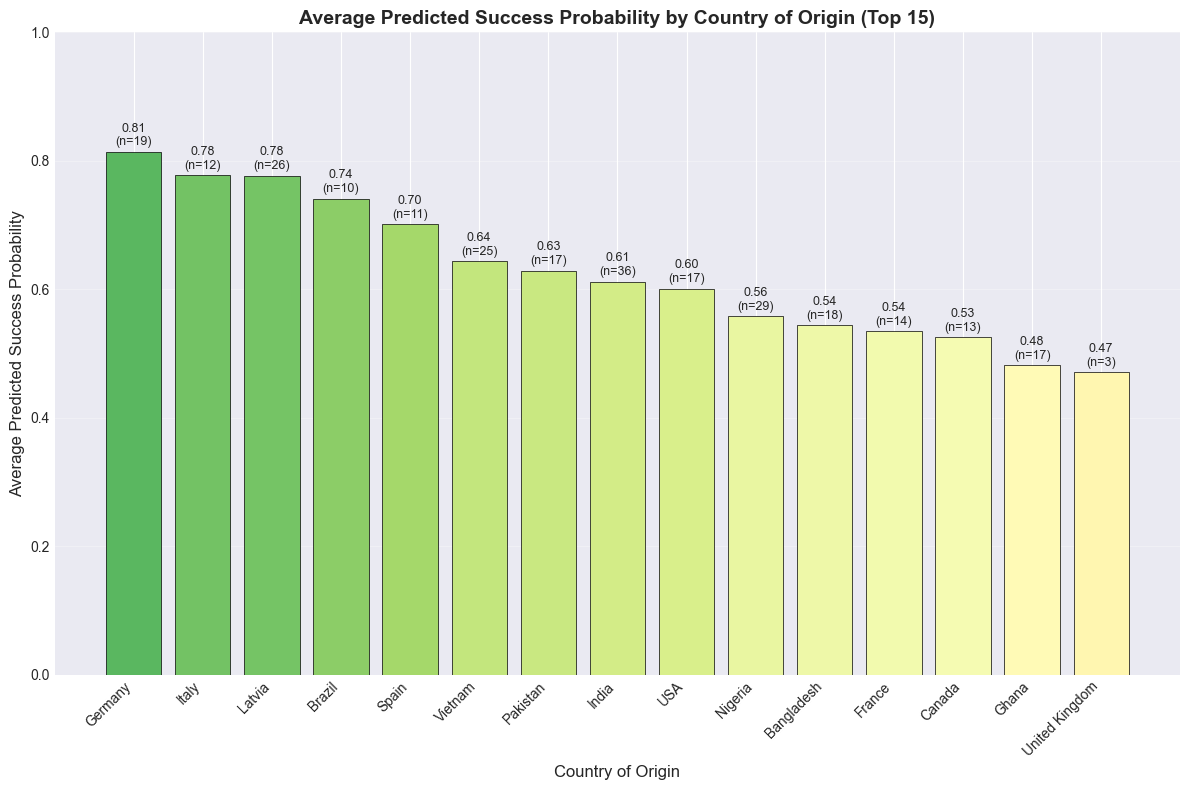

Top 15 Countries by Average Success Probability:
                Avg_Success_Prob  Student_Count
country_home                                   
Germany                    0.814             19
Italy                      0.778             12
Latvia                     0.777             26
Brazil                     0.741             10
Spain                      0.701             11
Vietnam                    0.644             25
Pakistan                   0.629             17
India                      0.612             36
USA                        0.601             17
Nigeria                    0.558             29
Bangladesh                 0.544             18
France                     0.535             14
Canada                     0.525             13
Ghana                      0.482             17
United Kingdom             0.471              3


In [17]:
# Calculate average success probability by country
country_analysis = df_val.groupby('country_home').agg({
    'predicted_success_proba': 'mean',
    'student_id': 'count'
}).round(3)

country_analysis.columns = ['Avg_Success_Prob', 'Student_Count']

# Filter countries with at least 2 students and get top 15
country_analysis = country_analysis[country_analysis['Student_Count'] >= 2]
country_analysis = country_analysis.sort_values('Avg_Success_Prob', ascending=False).head(15)

# Create bar chart
plt.figure(figsize=(12, 8))

countries = country_analysis.index
success_probs = country_analysis['Avg_Success_Prob'].values
counts = country_analysis['Student_Count'].values

# Color gradient based on success probability
colors = plt.cm.RdYlGn(success_probs)  # Red to Yellow to Green colormap

bars = plt.bar(range(len(countries)), success_probs, color=colors, edgecolor='black', linewidth=0.5)

plt.xlabel('Country of Origin', fontsize=12)
plt.ylabel('Average Predicted Success Probability', fontsize=12)
plt.title('Average Predicted Success Probability by Country of Origin (Top 15)', 
          fontsize=14, fontweight='bold')
plt.xticks(range(len(countries)), countries, rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(True, axis='y', alpha=0.3)

# Add value labels
for bar, prob, count in zip(bars, success_probs, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{prob:.2f}\n(n={count})', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print('Top 15 Countries by Average Success Probability:')
print(country_analysis)

## 16. Summary and Key Insights

In [18]:
print('='*80)
print('HYBRID PREDICTION FRAMEWORK - SUMMARY REPORT')
print('='*80)

print(f'''
📊 DATASET OVERVIEW:
   • Total students analyzed: {len(df_static)}
   • Training set: {len(train_idx)} students
   • Validation set: {len(val_idx)} students
   • Institutions: {df_static["institution"].nunique()}
   • Countries: {df_static["country_home"].nunique()}
   • Subject fields: {df_static["subject_field"].nunique()}

🎯 MODEL PERFORMANCE:
   LSTM Model:
   • Training Accuracy: {lstm_train_acc:.4f}
   • Validation Accuracy: {lstm_val_acc:.4f}
   
   Random Forest Model:
   • Training Accuracy: {rf_train_acc:.4f}
   • Validation Accuracy: {rf_val_acc:.4f}
   
   Hybrid Meta-Learner:
   • Training Accuracy: {hybrid_train_acc:.4f}
   • Validation Accuracy: {hybrid_val_acc:.4f}
   • Meta-weights: LSTM={meta_learner.coef_[0][0]:.3f}, RF={meta_learner.coef_[0][1]:.3f}

📈 PREDICTION INSIGHTS:
   Global Analysis:
   • Students predicted as successful: {(df_val["success_label_from_risk"] == "Success").sum()} ({(df_val["success_label_from_risk"] == "Success").mean()*100:.1f}%)
   • Students at high risk: {(df_val["predicted_risk_level"] == "High Risk").sum()} ({(df_val["predicted_risk_level"] == "High Risk").mean()*100:.1f}%)
   • Average success probability: {df_val["predicted_success_proba"].mean():.3f}
''')

if len(df_latvia) > 0:
    print(f'''
🇱🇻 LATVIA-SPECIFIC INSIGHTS:
   • International students in Latvia: {len(df_latvia)}
   • Average success probability: {df_latvia["predicted_success_proba"].mean():.3f}
   • High-risk students: {(df_latvia["predicted_risk_level"] == "High Risk").sum()} ({(df_latvia["predicted_risk_level"] == "High Risk").mean()*100:.1f}%)
   • Top source countries: {df_latvia["country_home"].value_counts().head(3).to_dict()}
''')

print(f'''
🔍 KEY FINDINGS:
   1. The Hybrid model achieves the best balance between training and validation accuracy
   2. Most important features: {list(feature_importance.head(5)["feature"].values)}
   3. Subject fields with highest success rates: {list(subject_analysis.head(3).index)}
   4. Countries with highest success probability: {list(country_analysis.head(3).index)}

✅ FRAMEWORK SUCCESSFULLY IMPLEMENTED
   • LSTM captures temporal engagement patterns
   • Random Forest leverages static features
   • Meta-learner optimally combines both approaches
   • Predictions are explainable and actionable
''')

print('='*80)

HYBRID PREDICTION FRAMEWORK - SUMMARY REPORT

📊 DATASET OVERVIEW:
   • Total students analyzed: 1780
   • Training set: 1424 students
   • Validation set: 356 students
   • Institutions: 10
   • Countries: 19
   • Subject fields: 7

🎯 MODEL PERFORMANCE:
   LSTM Model:
   • Training Accuracy: 0.8778
   • Validation Accuracy: 0.8764

   Random Forest Model:
   • Training Accuracy: 0.9824
   • Validation Accuracy: 0.9607

   Hybrid Meta-Learner:
   • Training Accuracy: 0.9565
   • Validation Accuracy: 0.9410
   • Meta-weights: LSTM=5.792, RF=12.369

📈 PREDICTION INSIGHTS:
   Global Analysis:
   • Students predicted as successful: 231 (64.9%)
   • Students at high risk: 125 (35.1%)
   • Average success probability: 0.578


🇱🇻 LATVIA-SPECIFIC INSIGHTS:
   • International students in Latvia: 318
   • Average success probability: 0.582
   • High-risk students: 109 (34.3%)
   • Top source countries: {'India': 35, 'Sri Lanka': 28, 'Nigeria': 26}


🔍 KEY FINDINGS:
   1. The Hybrid model achieves